## Imports

In [69]:
# import libraries
import pathlib
import os
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression

from sklearn import metrics

## Data Munging

In [96]:

# get the smaller files for faster prototyping
data_files = [f for f in os.listdir("./") if f.endswith(".csv") and "full" not in f]

data_sources = {}

# Load the both of the datasets for EDA.
for f in data_files:
    dataset_name = os.path.splitext(pathlib.Path(f).stem)[0]
    # WHAT KIND OF MONSTER USES SEMICOLONS IN A CSV?!
    data_sources[dataset_name] = pd.read_csv(f,sep=";")

# This portion of the code is an artifact of my EDA. I wanted to be able to easily switch between 
# datasets. I left it for posterity.
dataset_key = 'bank'
modeling_data = data_sources[dataset_key]

# Encode the categorical features as integers. This has a potential to cause problems by introducing an implied ordering.
# Also, it makes interpreting the coefficients of the model harder.
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
labelencoder = LabelEncoder()

for feature in categorical_features:
    modeling_data[feature] = labelencoder.fit_transform(modeling_data[feature])

for feature in categorical_features:
    modeling_data[feature] = modeling_data[feature].astype('int')

y = modeling_data['y']
X = modeling_data.drop(columns='y',axis=1)

# Store feature names to be used later.
feature_names = X.columns


# Building the model

In [97]:

# Train test split because we aren't interested in overfitting.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# I chose Newton with Conjugate Gradient because I wanted quadratic convergence. Also, L-BFGS 
# isn't really needed for this problem since the dataset isn't _that_ large.
#
# I chose L2 regularization because I wasn't concerned with having a sparse model. This is fortunate
# because I didn't really have much of a choice since sci-kit learn's implementation of Newton-Conjugate Gradient
# only supports L2 regularization.
clf = LogisticRegression(random_state=0, penalty='l2', solver = 'newton-cg', max_iter = 1000).fit(X_train, y_train)

## Validating the model

In [98]:
# Mean 
print('mean accuracy score on test set:', clf.score(X_test,y_test))

mean accuracy score on test set: 0.8719839142091153


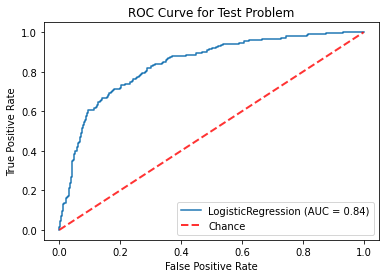

In [99]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

roc_viz = metrics.plot_roc_curve(clf, X_test, y_test,ax=ax).roc_auc 


ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
ax.legend(loc='lower right')
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC Curve for Test Problem")
plt.show()


## Interpreting the results

In [120]:
# Sorting the coefficients by absolute value; This will tell us which coefficients are
# most predictive.
sorted_coefficient_list = sorted(list(zip(feature_names,clf.coef_[0])), key = lambda x: abs(x[1]), reverse=True)

# This isn't super useful for the categorical variables.
for coefficient_tuple in sorted_coefficient_list:
    print(coefficient_tuple)

('loan', -0.8840014012399073)
('housing', -0.8307573835506502)
('contact', -0.6022200618458219)
('education', 0.19851756702273124)
('campaign', -0.1708647625698235)
('default', 0.1346249322650984)
('previous', 0.1112961514594328)
('poutcome', 0.10673231325900472)
('marital', 0.07576041203802585)
('job', 0.03232010999047084)
('month', 0.02004015121949757)
('age', 0.014602989198120178)
('duration', 0.004133818856164134)
('pdays', 0.0020876412781469108)
('day', -2.833325704823764e-05)
('balance', -2.2681197702227993e-05)


## Post hoc analysis
This model does a respectable job predicting outcomes. However, it isn't easy to interpret. This could be rectified by choosing to use one hot encoding instead of label encoding. A problem with one hot encoding is that it increases the dimensionality of the problem. That can be ameliorated by using L1 regularization as opposed to L2 as the L1 penalty term forces the model to become sparse. 